# Standard Imports

In [2]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

import tensorflow as tf
# Check if GPU is available
print("GPU Available:", tf.config.list_physical_devices('GPU'))

# Check if TensorFlow is using GPU acceleration
print("TensorFlow GPU Enabled:", tf.test.is_built_with_cuda())
print("TensorFlow GPU Device:", tf.test.gpu_device_name())

GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow GPU Enabled: True
TensorFlow GPU Device: /device:GPU:0


## Data

Release: Advance Monthly Sales for Retail and Food Services  
Units:  Millions of Dollars, Not Seasonally Adjusted

Frequency:  Monthly

The value for the most recent month is an advance estimate that is based on data from a subsample of firms from the larger Monthly Retail Trade Survey. The advance estimate will be superseded in following months by revised estimates derived from the larger Monthly Retail Trade Survey. The associated series from the Monthly Retail Trade Survey is available at https://fred.stlouisfed.org/series/MRTSSM448USN

Information about the Advance Monthly Retail Sales Survey can be found on the Census website at https://www.census.gov/retail/marts/about_the_surveys.html

Suggested Citation:
U.S. Census Bureau, Advance Retail Sales: Clothing and Clothing Accessory Stores [RSCCASN], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/RSCCASN, November 16, 2019.

https://fred.stlouisfed.org/series/RSCCASN

# Data Parsing
parse_dates = True because we are dealing with time series data

In [5]:
df = pd.read_csv('./Data/RSCCASN.csv',index_col='DATE',parse_dates=True)
df.head()

,RSCCASN
DATE,
1992-01-01,6938.0
1992-02-01,7524.0
1992-03-01,8475.0
1992-04-01,9401.0
1992-05-01,9558.0


In [7]:
df.columns = ['Sales']
df.head()

,Sales
DATE,
1992-01-01,6938.0
1992-02-01,7524.0
1992-03-01,8475.0
1992-04-01,9401.0
1992-05-01,9558.0


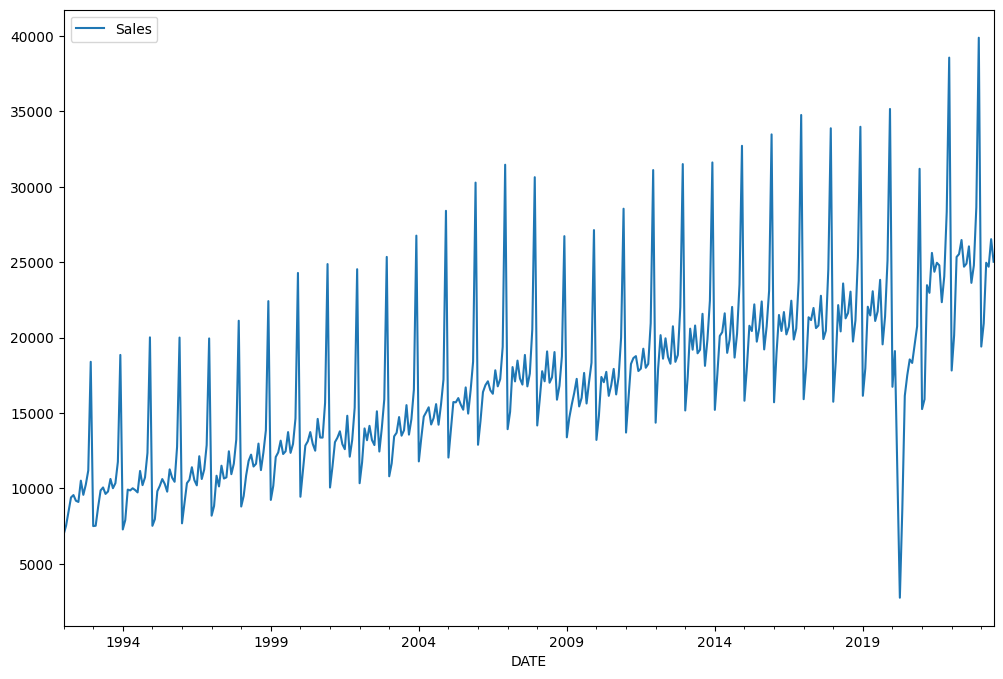

In [9]:
df.plot(figsize=(12,8));

# Train Test Split

In [10]:
len(df)

378

Data is monthly, let's forecast 1.5 years into the future.

In [11]:
len(df)- 18

360

In [12]:
test_size = 18

In [13]:
test_ind = len(df)- test_size

In [15]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]
train.head

<bound method NDFrame.head of               Sales
DATE               
1992-01-01   6938.0
1992-02-01   7524.0
1992-03-01   8475.0
1992-04-01   9401.0
1992-05-01   9558.0
...             ...
2021-08-01  24789.0
2021-09-01  22347.0
2021-10-01  24062.0
2021-11-01  28340.0
2021-12-01  38564.0

[360 rows x 1 columns]>

In [16]:
test

,Sales
DATE,
2022-01-01,17817.0
2022-02-01,20152.0
2022-03-01,25347.0
2022-04-01,25539.0
2022-05-01,26470.0
2022-06-01,24701.0
2022-07-01,24904.0
2022-08-01,26049.0
2022-09-01,23629.0


# Normalizing Data

In [17]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaled_train = scaler.fit_transform(train)
scaled_test = scaler.transform(test)

# Time Series Generator

This class takes in a sequence of data-points gathered at
equal intervals, along with time series parameters such as
stride, length of history, etc., to produce batches for
training/validation.

#### Arguments
    data: Indexable generator (such as list or Numpy array)
        containing consecutive data points (timesteps).
        The data should be at 2D, and axis 0 is expected
        to be the time dimension.
    targets: Targets corresponding to timesteps in `data`.
        It should have same length as `data`.
    length: Length of the output sequences (in number of timesteps).
    sampling_rate: Period between successive individual timesteps
        within sequences. For rate `r`, timesteps
        `data[i]`, `data[i-r]`, ... `data[i - length]`
        are used for create a sample sequence.
    stride: Period between successive output sequences.
        For stride `s`, consecutive output samples would
        be centered around `data[i]`, `data[i+s]`, `data[i+2*s]`, etc.
    start_index: Data points earlier than `start_index` will not be used
        in the output sequences. This is useful to reserve part of the
        data for test or validation.
    end_index: Data points later than `end_index` will not be used
        in the output sequences. This is useful to reserve part of the
        data for test or validation.
    shuffle: Whether to shuffle output samples,
        or instead draw them in chronological order.
    reverse: Boolean: if `true`, timesteps in each output sample will be
        in reverse chronological order.
    batch_size: Number of timeseries samples in each batch
        (except maybe the last one).

In [18]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [19]:
# Let's redefine to get 12 months back and then predict the next month out
length = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=1)

In [21]:
# What does the first batch look like?
X,y = generator[0]

print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.11688819 0.13325142 0.15980677 0.18566402 0.19004803 0.17954875
 0.17734279 0.21671507 0.19046688 0.20948285 0.23553557 0.43680889]
Predict this y: 
 [[0.1326371]]


# Model Creation

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

# We're only using one feature in our time series
n_features = 1

# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


# EarlyStopping and creating a Validation Generator

NOTE: The scaled_test dataset size MUST be greater than your length chosen for your batches. Review video for more info on this.

In [23]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',patience=2)
validation_generator = TimeseriesGenerator(scaled_test,scaled_test, length=length, batch_size=1)

# fit model
model.fit_generator(generator,epochs=20,
                    validation_data=validation_generator,
                    callbacks=[early_stop])

Epoch 1/20


C:\Users\prath\AppData\Local\Temp\ipykernel_6132\1475560418.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator,epochs=20,


348/348 [==============================] - 17s 41ms/step - loss: 0.0209 - val_loss: 0.0107
Epoch 2/20
348/348 [==============================] - 12s 35ms/step - loss: 0.0149 - val_loss: 0.0068
Epoch 3/20
348/348 [==============================] - 13s 37ms/step - loss: 0.0103 - val_loss: 0.0054
Epoch 4/20
348/348 [==============================] - 13s 38ms/step - loss: 0.0063 - val_loss: 0.0029
Epoch 5/20
348/348 [==============================] - 14s 40ms/step - loss: 0.0068 - val_loss: 0.0100
Epoch 6/20
348/348 [==============================] - 14s 40ms/step - loss: 0.0056 - val_loss: 0.0059


<Axes: >

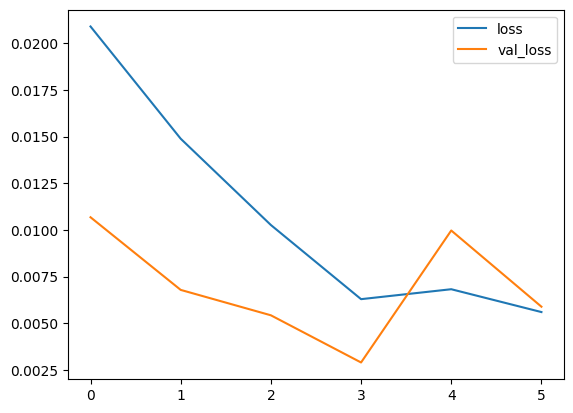

In [24]:
losses = pd.DataFrame(model.history.history)
losses.plot()

# Evaluate on Test Data

In [28]:
first_eval_batch = scaled_train[-length:]
first_eval_batch = first_eval_batch.reshape((1, length, n_features))

print(model.predict(first_eval_batch), scaled_test[0])

1/1 [==============================] - 0s 50ms/step


[[0.4892497]] [0.42066905]


In [29]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 33ms/step


In [30]:
true_predictions = scaler.inverse_transform(test_predictions)

In [31]:
test['Predictions'] = true_predictions

C:\Users\prath\AppData\Local\Temp\ipykernel_6132\4269337381.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


In [32]:
test

,Sales,Predictions
DATE,,
2022-01-01,17817.0,20273.010481
2022-02-01,20152.0,21733.059112
2022-03-01,25347.0,25690.081543
2022-04-01,25539.0,25376.224152
2022-05-01,26470.0,28042.921210
2022-06-01,24701.0,26969.157777
2022-07-01,24904.0,27665.695091
2022-08-01,26049.0,27637.220040
2022-09-01,23629.0,25488.399630


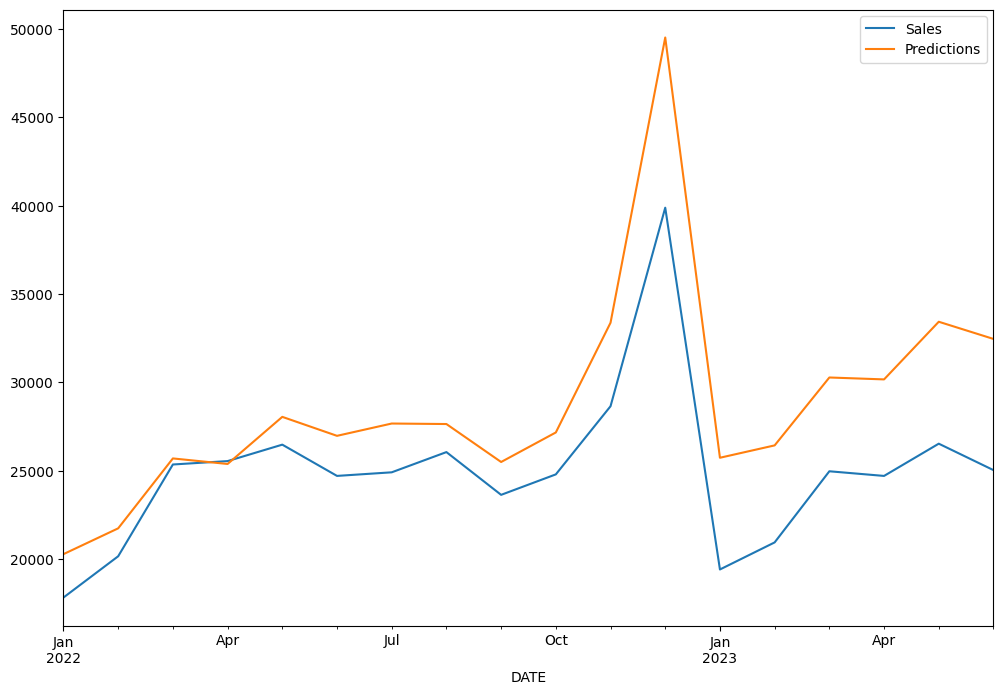

In [34]:
test.plot(figsize=(12,8));